In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Smooth image with median blur

In [2]:
def smooth_img(img, kernel_size = 5):
    smoothed = cv2.medianBlur(img, kernel_size)
    return smoothed

In [3]:
def canny_edge_detect(img, low_thresh=100, high_thresh=150):
    canny = cv2.Canny(img, low_thresh, high_thresh)
    return canny

# Generate Hough-space representation of the edge map

In [4]:
def hough(edges, rho_bin_width = 1, angle_bin_width = 1, thresh = 50):
    height, width = edges.shape
    diag_length = int(np.ceil(np.sqrt(height**2 + width**2)))
    num_bins = 180 // angle_bin_width
    bins = np.linspace(0, 2 * np.pi - 0.02, num_bins)

    hough_space = np.zeros((diag_length // rho_bin_width, num_bins))

    cos_theta = np.cos(bins)
    sin_theta = np.sin(bins)

    for y in range(height):
        for x in range(width):
            if edges[y, x] == 0:
                continue
            rhos = np.round(y * sin_theta + x * cos_theta).astype(np.int32)

            for i, rho in enumerate(rhos):
                if rho >= 0:
                    hough_space[rho // rho_bin_width, i] += 1
    
    hough_space[hough_space < thresh] = 0
    return hough_space

# Apply non maximum supression

In [5]:
def nms(hough_space):
    n_cols, n_rows = hough_space.shape

    for y in range(n_cols):
        for x in range(n_rows):
            cell = hough_space[y, x]
            neighbourhood = [cell]
            if x+1 < n_rows:
                neighbourhood.append(hough_space[y, x+1])
            if y+1 < n_cols:
                neighbourhood.append(hough_space[y+1, x])
            if y-1 >= 0:
                neighbourhood.append(hough_space[y-1, x])
            if x-1 >= 0:
                neighbourhood.append(hough_space[y, x-1])

            if cell != max(neighbourhood):
                hough_space[y, x] = 0

# Draw detected lines on the image

In [6]:
def draw_lines(img, hough_space, rho_bin_width = 1, line_thickness=1):
    rho_bins_num, theta_bins_num = hough_space.shape
    height, width = img.shape[:2]
    diag_length = int(np.ceil(np.sqrt(height**2 + width**2)))
    
    thetas = np.linspace(0, 2 * np.pi - 0.02, theta_bins_num)
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)

    lines_drawn = 0

    for rho in range(rho_bins_num):
        scaled_rho = rho * rho_bin_width
        for idx in range(theta_bins_num):
            if hough_space[rho, idx]:
                lines_drawn += 1
                points = []
                x_intercept_upper = int(scaled_rho / (cos_theta[idx] + 0.001))
                if x_intercept_upper >= 0 and x_intercept_upper < width:
                    points.append((x_intercept_upper, 0))

                x_intercept_lower = int((scaled_rho - (height - 1) * sin_theta[idx]) / (cos_theta[idx] + 0.001))
                if x_intercept_lower >= 0 and x_intercept_lower < width:
                    points.append((x_intercept_lower, height - 1))

                y_intercept_left = int(scaled_rho / (sin_theta[idx] + 0.001))
                if y_intercept_left >= 0 and y_intercept_left < height:
                    points.append((0, y_intercept_left))
                
                y_intercept_right = int((scaled_rho - (width - 1) * cos_theta[idx]) / (sin_theta[idx] + 0.001))
                if y_intercept_right >= 0 and y_intercept_right < height:
                    points.append((width - 1, y_intercept_right))

                assert len(points) > 1
                img = cv2.line(img, points[0], points[1], (0, 255, 0), line_thickness)
    print(f'Lines drawn count = {lines_drawn}')
    return img


# Sample image

In [7]:
def load_and_view_img(path):
    # Load image
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Change to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply median blur
    img_smoothed = smooth_img(img_gray)
    # Apply canny edge detection
    canny = canny_edge_detect(img_smoothed)

    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.title('Grayscale image')
    plt.imshow(img_gray, cmap='gray')

    plt.subplot(2, 2, 3)
    plt.axis('off')
    plt.title('Median-blurred image')
    plt.imshow(img_smoothed, cmap='gray')


    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.title('Edge map output of Canny\'s algorithm')
    plt.imshow(canny, cmap='gray')

    plt.show()

    return img, canny

In [8]:
def define_roi(img, coords):
    min_x = 1e9
    min_y = 1e9
    max_x = 0
    max_y = 0

    for point in coords:
        min_x = min(min_x, point[0])
        max_x = max(max_x, point[0])
        min_y = min(min_y, point[1])
        max_y = max(max_y, point[1])

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask = cv2.fillConvexPoly(mask, coords, 1)

    img[mask != 1] = 0
    return img[min_y: max_y, min_x: max_x], [min_y, max_y, min_x, max_x]

In [9]:
def test_img(img, canny, coords, rho_bin_width=1, theta_bin_width=1, hough_thresh=130, line_thickness=1):
    roi_canny, bbox = define_roi(canny, coords)
    # Apply hough transform
    mat = hough(roi_canny, rho_bin_width, theta_bin_width, hough_thresh)
    # Apply non-maximum supression
    nms(mat)

    img_draw = img.copy()
    roi_draw = img_draw[bbox[0]: bbox[1], bbox[2]: bbox[3]]
    draw_lines(roi_draw, mat, rho_bin_width, line_thickness)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.title('Lines detected by Hough transform')
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))

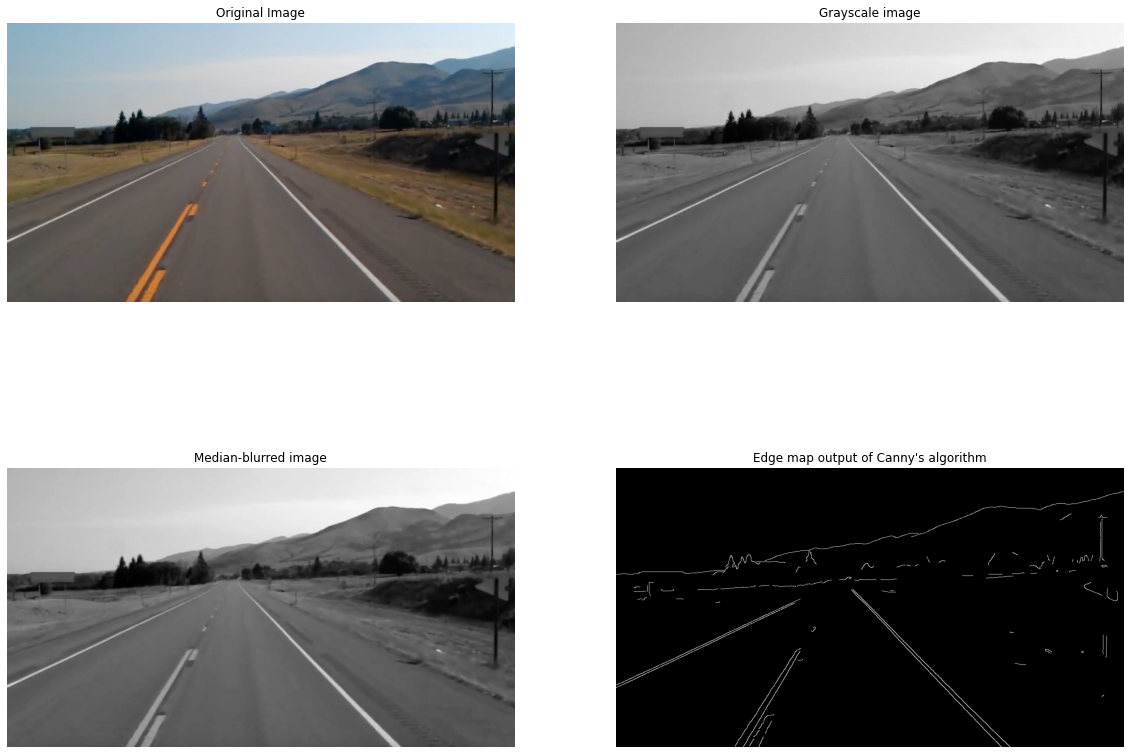

In [10]:
coords = np.array([(0, 700), (0, 510), (350, 360), (670, 340), (1100, 700)])
img, canny = load_and_view_img('testHough.jpg')

Lines drawn count = 9


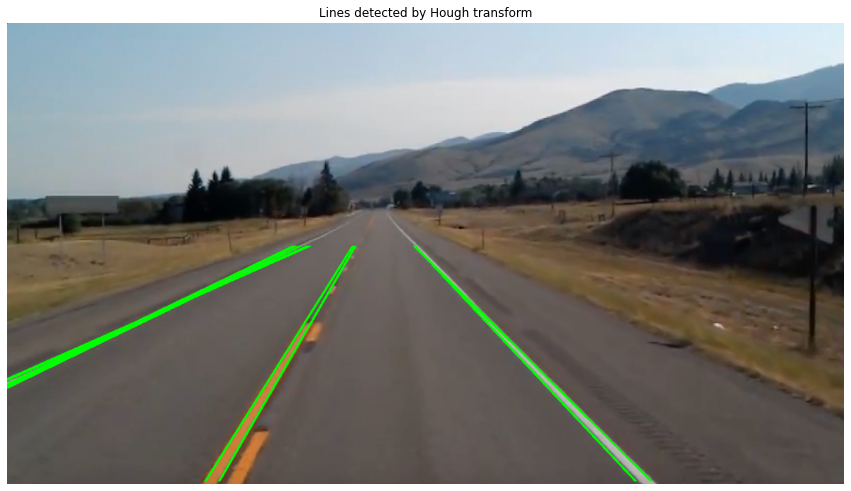

In [11]:
test_img(img, canny, coords, 1, 1, 110, 2)

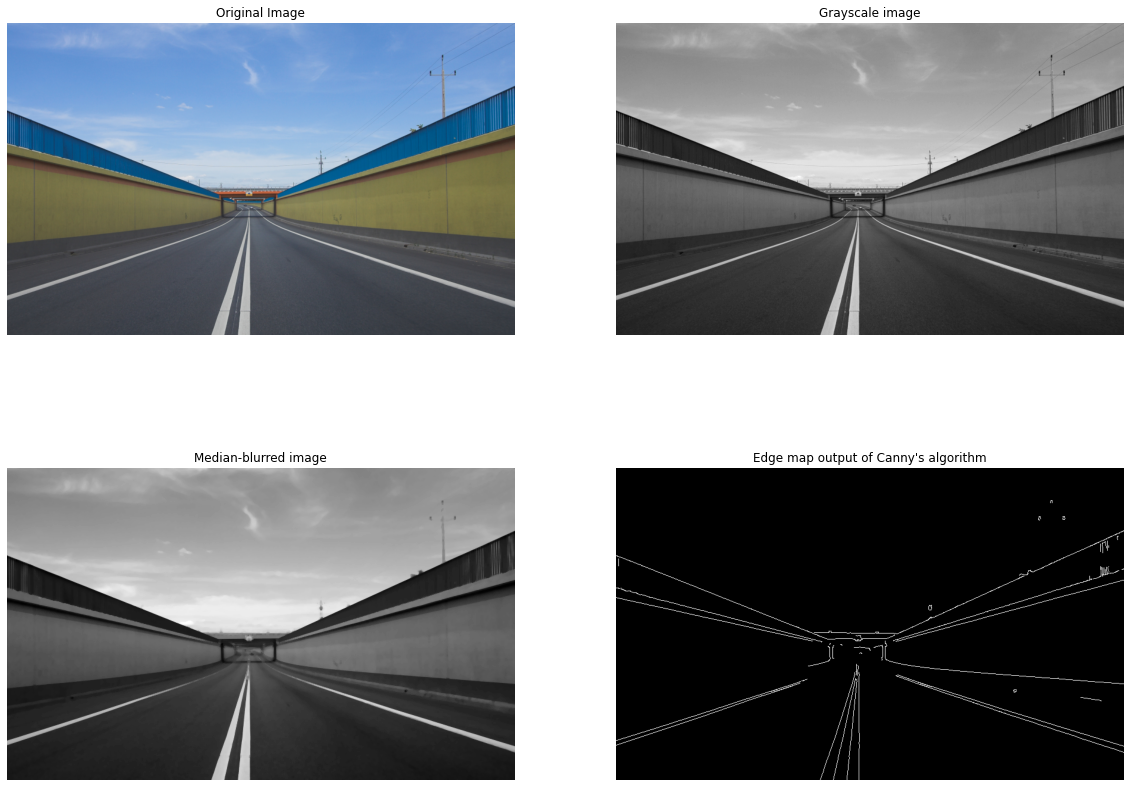

In [12]:
coords = np.array([(0, 520), (0, 430), (305, 350), (850, 450), (850, 520)])
img, canny = load_and_view_img('testHough1.png')

Lines drawn count = 4


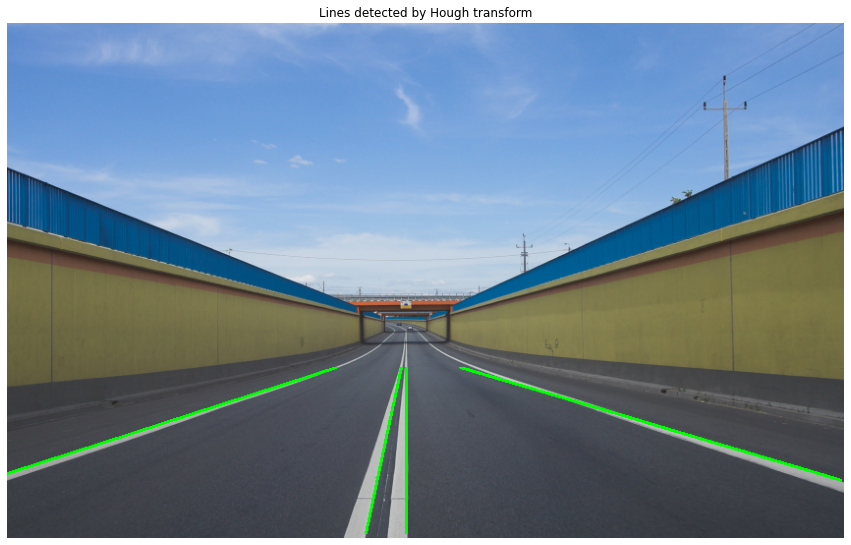

In [13]:
test_img(img, canny, coords, 1, 1, 110, 2)